<a href="https://colab.research.google.com/github/Laere11/Laere11/blob/Batteries/ML_Cell_Analysis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is an updated Python script that:

Uses the dataset for the 86 cells (voltage, variation, z-score).
Performs PCA on the three features (Voltage, Variation_mV, Z_score).
Labels outliers on the PCA plot according to the new definition:
 PCA components 1 is > 15 or < -15,
 PCA components 2 is > 0.004 or < -0.004.

Uses Isolation Forest for anomaly detection on the same features, then labels the anomaly cells (in blue) on the Battery Cell Voltage Anomaly Detection plot.
Creates and prints two tables of outliers:
Table 1 (PCA Outliers): Cell #, PCA1, PCA2
Table 2 (Anomaly Detection Outliers): Cell #, Voltage.


Important:
Depending on the data scale, it’s possible that few or no points will satisfy the specified PCA outlier thresholds (±15 for PCA1, ±0.004 for PCA2). This script will still label any that do.
If no points meet those thresholds, no labels will appear, and the PCA outlier table will be empty.

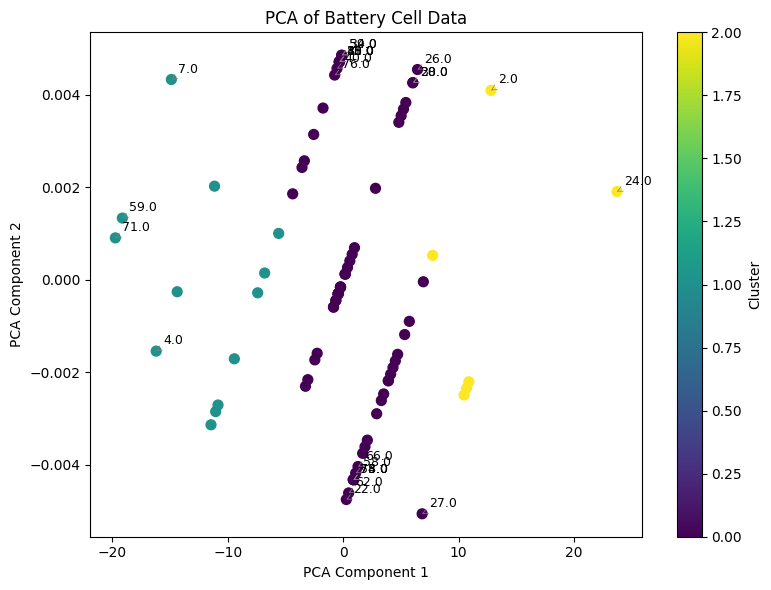

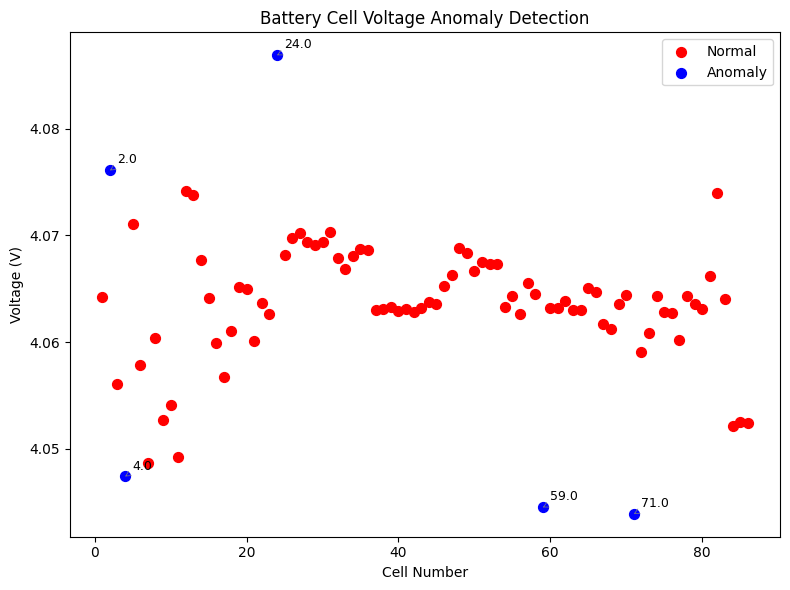


=== PCA Outliers Table ===
 Cell       PCA1      PCA2
    2  12.815477  0.004095
    4 -16.203394 -0.001541
    7 -14.888112  0.004331
   15  -0.328485  0.004718
   22   0.276750 -0.004750
   24  23.734828  0.001909
   26   6.445733  0.004547
   27   6.848732 -0.005058
   28   6.041258  0.004261
   30   6.041258  0.004261
   38  -0.328486  0.004713
   39  -0.126248  0.004855
   40  -0.530723  0.004570
   41  -0.328486  0.004713
   54  -0.126248  0.004855
   55   0.883463 -0.004322
   58   1.085701 -0.004179
   59 -19.135100  0.001335
   62   0.478988 -0.004607
   66   1.287938 -0.004036
   71 -19.741812  0.000907
   74   0.883463 -0.004322
   76  -0.732961  0.004427
   78   0.883463 -0.004322
   80  -0.328486  0.004713

=== Anomaly Detection Outliers Table ===
 Cell  Voltage
    2   4.0761
    4   4.0474
   24   4.0869
   59   4.0445
   71   4.0439


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# -------------------------------------------------------------------
# 1) Load Your Exact Data for the 86 Cells into a DataFrame
# -------------------------------------------------------------------
data = {
    'Cell': list(range(1, 87)),
    'Voltage': [
        4.0642, 4.0761, 4.0561, 4.0474, 4.0711, 4.0579, 4.0487, 4.0604, 4.0527, 4.0541, 4.0492, 4.0742,
        4.0738, 4.0677, 4.0641, 4.0599, 4.0567, 4.0610, 4.0652, 4.0650, 4.0601, 4.0637, 4.0626, 4.0869,
        4.0682, 4.0698, 4.0702, 4.0694, 4.0691, 4.0694, 4.0703, 4.0679, 4.0669, 4.0681, 4.0687, 4.0686,
        4.0630, 4.0631, 4.0633, 4.0629, 4.0631, 4.0628, 4.0632, 4.0638, 4.0636, 4.0653, 4.0663, 4.0688,
        4.0684, 4.0667, 4.0675, 4.0673, 4.0673, 4.0633, 4.0643, 4.0626, 4.0655, 4.0645, 4.0445, 4.0632,
        4.0632, 4.0639, 4.0630, 4.0630, 4.0651, 4.0647, 4.0617, 4.0612, 4.0636, 4.0644, 4.0439, 4.0591,
        4.0609, 4.0643, 4.0628, 4.0627, 4.0602, 4.0643, 4.0636, 4.0631, 4.0662, 4.0740, 4.0640, 4.0521,
        4.0525, 4.0524
    ],
    'Variation_mV': [
        +0.8, +12.7, -7.3, -16.0, +7.7, -5.5, -14.7, -3.0, -10.7, -9.3, -14.2, +10.8,
        +10.4, +4.3, -0.3, -3.5, -6.7, -2.4, -0.2, -0.4, -3.3, +0.3, -0.8, +23.5,
        +4.8, +6.4, +6.8, +6.0, +5.7, +6.0, +6.9, +4.5, +3.5, +4.7, +5.3, +5.2,
        -0.4, -0.3, -0.1, -0.5, -0.3, -0.6, -0.2, +0.4, +0.2, +1.9, +2.9, +5.4,
        +5.0, +3.3, +4.1, +3.9, +3.9, -0.1, +0.9, -0.8, +2.1, +1.1, -18.9, -0.2,
        -0.2, +0.5, -0.4, -0.4, +1.7, +1.3, -1.7, -2.2, +0.2, +1.0, -19.5, -4.3,
        -2.5, +0.9, -0.6, -0.7, -3.2, +0.9, +0.2, -0.3, +2.8, +10.6, +0.6, -11.3,
        -10.9, -11.0
    ],
    'Z_score': [
        +0.12, +1.90, -1.09, -2.39, +1.15, -0.82, -2.19, -0.45, -1.60, -1.39, -2.12, +1.61,
        +1.55, +0.64, -0.04, -0.52, -1.00, -0.36, -0.03, -0.06, -0.49, +0.04, -0.12, +3.51,
        +0.72, +0.96, +1.01, +0.90, +0.85, +0.90, +1.03, +0.67, +0.52, +0.70, +0.79, +0.78,
        -0.06, -0.04, -0.01, -0.07, -0.04, -0.09, -0.03, +0.06, +0.03, +0.28, +0.43, +0.81,
        +0.75, +0.49, +0.61, +0.58, +0.58, -0.01, +0.13, -0.12, +0.31, +0.16, -2.82, -0.03,
        -0.03, +0.07, -0.06, -0.06, +0.25, +0.19, -0.25, -0.33, +0.03, +0.15, -2.91, -0.64,
        -0.37, +0.13, -0.09, -0.10, -0.48, +0.13, +0.03, -0.04, +0.42, +1.58, +0.09, -1.69,
        -1.63, -1.64
    ]
}

df = pd.DataFrame(data)

# -------------------------------------------------------------------
# 2) K-Means Clustering (optional, for color-coding in PCA)
# -------------------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Voltage', 'Variation_mV', 'Z_score']])

# -------------------------------------------------------------------
# 3) PCA for Visualization
# -------------------------------------------------------------------
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(df[['Voltage', 'Variation_mV', 'Z_score']])
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

# -------------------------------------------------------------------
# 4) Isolation Forest for Anomaly Detection
# -------------------------------------------------------------------
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(df[['Voltage', 'Variation_mV', 'Z_score']])
# Anomaly = -1 indicates an outlier

# -------------------------------------------------------------------
# 5) PCA Plot with Updated Outlier Definition & Labels
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['PCA1'], df['PCA2'],
                      c=df['Cluster'], cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Battery Cell Data')
cbar = plt.colorbar(scatter, label='Cluster')

# Identify PCA outliers with the new criteria:
# PCA1 > 15 or PCA1 < -15, or PCA2 > 0.004 or PCA2 < -0.004
pca_outliers = df[
    ((df['PCA1'] > 15) | (df['PCA1'] < -15)) |
    ((df['PCA2'] > 0.004) | (df['PCA2'] < -0.004))
]

for i, row in pca_outliers.iterrows():
    plt.annotate(
        str(row['Cell']),
        xy=(row['PCA1'], row['PCA2']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', lw=0.5, color='gray')
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 6) Anomaly Detection Plot with Outlier Labels
# -------------------------------------------------------------------
plt.figure(figsize=(8, 6))

# Plot normal points (Anomaly = 1) in red, outliers (Anomaly = -1) in blue
normal_cells = df[df['Anomaly'] == 1]
anomaly_cells = df[df['Anomaly'] == -1]

plt.scatter(normal_cells['Cell'], normal_cells['Voltage'],
            color='red', label='Normal', s=50)
plt.scatter(anomaly_cells['Cell'], anomaly_cells['Voltage'],
            color='blue', label='Anomaly', s=50)

plt.xlabel('Cell Number')
plt.ylabel('Voltage (V)')
plt.title('Battery Cell Voltage Anomaly Detection')
plt.legend()

# Label the anomaly cells in blue
for i, row in anomaly_cells.iterrows():
    plt.annotate(
        str(row['Cell']),
        xy=(row['Cell'], row['Voltage']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', lw=0.5, color='gray')
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 7) Create & Print Tables of Outliers
# -------------------------------------------------------------------

# --- Table 1: PCA Outliers (Cell #, PCA1, PCA2) ---
pca_outliers_table = pca_outliers[['Cell', 'PCA1', 'PCA2']].copy()
print("\n=== PCA Outliers Table ===")
print(pca_outliers_table.to_string(index=False))

# --- Table 2: Anomaly Detection Outliers (Cell #, Voltage) ---
anomaly_outliers = df[df['Anomaly'] == -1]
anomaly_outliers_table = anomaly_outliers[['Cell', 'Voltage']].copy()
print("\n=== Anomaly Detection Outliers Table ===")
print(anomaly_outliers_table.to_string(index=False))


Explanation

Data Import
We explicitly load the exact 86‐cell dataset you provided, ensuring consistency with your original table.

PCA

We perform PCA on three features: Voltage, Variation_mV, Z_score.
The resulting components are stored as PCA1 and PCA2.

Outlier Criteria (PCA Plot)

PCA outliers are defined as those points where PCA1 is outside ±15 or PCA2 is outside ±0.004.
Any cells meeting these conditions are labeled with their Cell number on the PCA plot.

Isolation Forest

Flags Anomaly = –1 for outlier cells, +1 for normal cells.
The anomaly cells are plotted in blue on the “Battery Cell Voltage Anomaly Detection” chart, with their labels (cell numbers) shown.

Outlier Tables

Table 1 (PCA Outliers): Lists Cell, PCA1, PCA2.

Table 2 (Anomaly Detection Outliers): Lists Cell, Voltage for those cells flagged as outliers by Isolation Forest.

Note: If no points meet the PCA outlier thresholds, the PCA outliers table will be empty and no labels will appear on the plot. The same applies if Isolation Forest finds no anomalies. Adjust thresholds and contamination levels as needed to capture the behavior you’re interested in.